In [1]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv

--2024-10-09 06:08:03--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 298573 (292K) [text/plain]
Saving to: ‘laptops.csv.2’

laptops.csv.2       100%[===================>] 291.58K  --.-KB/s    in 0.03s   

2024-10-09 06:08:03 (9.01 MB/s) - ‘laptops.csv.2’ saved [298573/298573]



In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('/content/laptops.csv')
print(df.shape)
df.head()

(2160, 12)


,Laptop,Status,Brand,Model,CPU,RAM,Storage,Storage type,GPU,Screen,Touch,Final Price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,NaN,15.6,No,1009.00
1,Alurin Go Start Intel Celeron N4020/8GB/256GB ...,New,Alurin,Go,Intel Celeron,8,256,SSD,NaN,15.6,No,299.00
2,ASUS ExpertBook B1 B1502CBA-EJ0424X Intel Core...,New,Asus,ExpertBook,Intel Core i3,8,256,SSD,NaN,15.6,No,789.00
3,MSI Katana GF66 12UC-082XES Intel Core i7-1270...,New,MSI,Katana,Intel Core i7,16,1000,SSD,RTX 3050,15.6,No,1199.00
4,HP 15S-FQ5085NS Intel Core i5-1235U/16GB/512GB...,New,HP,15S,Intel Core i5,16,512,SSD,NaN,15.6,No,669.01


In [4]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

df = df.loc[:, ['ram', 'storage', 'screen', 'final_price']]

# EDA

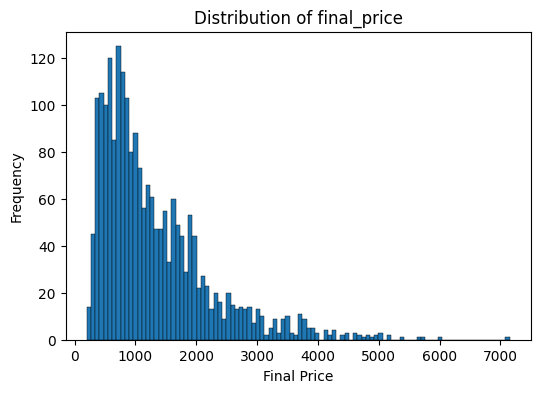

In [5]:
# the distribution has a long tail
plt.figure(figsize=(6, 4))

sns.histplot(df.final_price, bins=100, alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Final Price')
plt.title('Distribution of final_price')

plt.show()

# Question 1.
**Answer**: column with missing value in `screen`

In [6]:
df.isnull().sum()

,0
ram,0
storage,0
screen,4
final_price,0


# Question 2
**Answer**: median with for variable ram is `16`

In [7]:
df['ram'].median()

16.0

## prepare and split dataset

In [8]:
def split_data(df, seed):
  np.random.seed(seed)

  n = len(df)

  n_val = int(0.2 * n)
  n_test = int(0.2 * n)
  n_train = n - (n_val + n_test)

  idx = np.arange(n)
  np.random.shuffle(idx)

  df_shuffled = df.iloc[idx]

  df_train = df_shuffled.iloc[:n_train].copy()
  df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
  df_test = df_shuffled.iloc[n_train+n_val:].copy()

  return df_train, df_val, df_test

In [9]:
df_train, df_val, df_test = split_data(df, seed=42)

# Question 3
**Answer**: with 0 gives lower result

In [10]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)

    return w[0], w[1:]

def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [11]:
features = ['ram', 'storage', 'screen']

def prepare_X(df):
    df = df.copy()
    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

def prepare_X_mean(df, mean):
    df = df.copy()
    df_num = df[features]
    df_num['screen'] = df_num['screen'].fillna(mean)
    X = df_num.values
    return X

In [12]:
# results with filling 0
y_train = df_train.final_price.values
y_val = df_val.final_price.values

del df_train['final_price']
del df_val['final_price']
del df_test['final_price']

X_train = prepare_X(df_train)
X_val = prepare_X(df_val)



w_0, w = train_linear_regression(X_train, y_train)
y_pred = w_0 + X_val.dot(w)

score = rmse(y_val, y_pred)
print('RMSE filling with 0:', round(score, 2))

RMSE filling with 0: 597.36


In [13]:
# results with filling mean


X_train = prepare_X_mean(df_train, df_train['screen'].mean())
X_val = prepare_X_mean(df_val, df_train['screen'].mean())

w_0, w = train_linear_regression(X_train, y_train)
y_pred = w_0 + X_val.dot(w)

score = rmse(y_val, y_pred)
print('RMSE filling with mean:', round(score, 2))

RMSE filling with mean: 600.27


# Question 4:
**Answer**: r=10

In [14]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)

    return w[0], w[1:]

In [15]:

X_train = prepare_X(df_train)
X_val = prepare_X(df_val)

rmse_min = 10000000
r_min = ""
for r in [0, 0.01, 1, 10, 100]:
  w_0, w = train_linear_regression_reg(X_train, y_train, r)
  y_pred = w_0 + X_val.dot(w)
  score = rmse(y_val, y_pred)
  if rmse_min > score:
    rmse_min = score
    r_min = r
  print(r, score)

print("Minimum r:", r_min, "With score:", rmse_min)

0 597.3635593619622
0.01 597.3616819856013
1 597.2121215589519
10 597.0587680661115
100 597.9032640603043
Minimum r: 10 With score: 597.0587680661115


# Question 5
**Answer**: 29.176

In [16]:
seed_vals = []
for seed in  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
  df_train, df_val, df_test = split_data(df, seed)

  y_train = df_train.final_price.values
  y_val = df_val.final_price.values

  del df_train['final_price']
  del df_val['final_price']
  del df_test['final_price']

  X_train = prepare_X(df_train)
  X_val = prepare_X(df_val)

  w_0, w = train_linear_regression(X_train, y_train)
  y_pred = w_0 + X_val.dot(w)

  score = rmse(y_val, y_pred)
  print(seed, score)
  seed_vals.append(score)

0 565.4520868771027
1 636.7985423056726
2 588.9558697907962
3 597.8148920012521
4 571.962791511102
5 573.2383256618949
6 647.3438328407208
7 550.4398184485952
8 587.333503616991
9 576.1017929433108


In [17]:
std = np.std(seed_vals)
print(round(std, 3))

29.176


# Question 6
**Answer** 608.60

In [18]:
# dataset split
df_train, df_val, df_test = split_data(df, seed=9)

In [19]:
# combine datasets
df_train = pd.concat([df_train, df_val]).reset_index(drop=True)

In [20]:
# prepare data
X_train = prepare_X(df_train)
y_train = df_train.final_price.values

X_test = prepare_X(df_test)
y_test = df_test.final_price.values

In [21]:
# train and make prediction
w_0, w = train_linear_regression_reg(X_train, y_train, r=0.001)
y_pred = w_0 + X_test.dot(w)

In [22]:
score = rmse(y_test, y_pred)
print(score)

608.609982204956
